Arquivo '../Data/mglu3_dataset_projecao_final.csv' carregado com sucesso.
--- Arquivo Original (dataset_projecao_final) ---
    Ano  MGLU3_Cresc_AA  Margem_Bruta       ROE  Giro_Ativo  \
0  2011      -16.252091     33.403382  0.598873    0.368913   
1  2012      -65.430303     32.856858 -0.280447    0.367336   
2  2013      126.731252     31.235383  4.429431    1.269443   
3  2014        8.922955     27.532161  4.429686    0.517182   
4  2015       -5.578938     28.720813 -2.288484    0.452114   

   Liquidez_Corrente  PIB_Var_Real  Consumo_Familia_Var_Real  
0           1.146323           4.0                       4.8  
1           1.184715           1.9                       3.5  
2           1.193355           3.0                       3.5  
3           1.195992           0.5                       2.3  
4           1.317996          -3.5                      -3.2  
------------------------------------------

--- AVALIAÇÃO DO MODELO RANDOM FOREST ---
Modelo Random Forest Treinado com

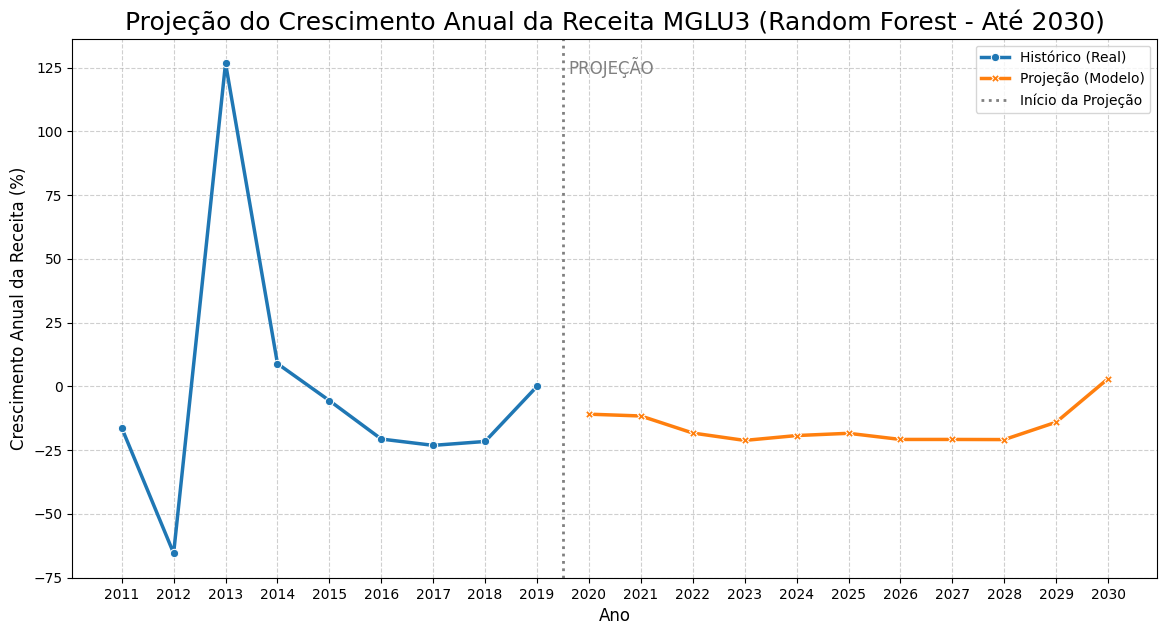

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define o caminho base de onde o script está
# Usando Path.cwd() ou o caminho relativo
PASTA_DATA = Path('../Data')

# CAMINHO LOCAL
ARQUIVO_MODELO_FULL_PATH = PASTA_DATA / 'mglu3_dataset_projecao_final.csv'

try:
    df_modelo_final = pd.read_csv(ARQUIVO_MODELO_FULL_PATH)
    print(f"Arquivo '{ARQUIVO_MODELO_FULL_PATH}' carregado com sucesso.")
    print("--- Arquivo Original (dataset_projecao_final) ---")
    print(df_modelo_final.head())
    print("------------------------------------------")
except FileNotFoundError:
    print("ERRO: O arquivo final para o modelo não foi encontrado.")
    
Y = df_modelo_final['MGLU3_Cresc_AA']
X = df_modelo_final.drop(columns=['Ano', 'MGLU3_Cresc_AA'])

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42) 
modelo_rf.fit(X, Y)

print("\n--- AVALIAÇÃO DO MODELO RANDOM FOREST ---")

Y_pred_treino = modelo_rf.predict(X)
r2_rf = r2_score(Y, Y_pred_treino)
mse_rf = mean_squared_error(Y, Y_pred_treino)
print(f"Modelo Random Forest Treinado com dados históricos.")
print(f"R-Quadrado (R²) na Amostra de Treinamento: {r2_rf:.4f}")
print(f"Erro Quadrático Médio (MSE): {mse_rf:.2f}")

importancia = pd.Series(modelo_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportância das Variáveis (Feature Importance):")
print(importancia)
print("------------------------------------------")

ANOS_PROJECAO = np.arange(df_modelo_final['Ano'].max() + 1, 2031)

ultimo_ano = df_modelo_final.iloc[-1]
PIB_PROJ = np.linspace(1.5, 2.5, len(ANOS_PROJECAO))
CONS_PROJ = np.linspace(2.0, 3.0, len(ANOS_PROJECAO))
MARGEM_BRUTA_PROJ = np.linspace(ultimo_ano['Margem_Bruta'], 35.0, len(ANOS_PROJECAO))
ROE_PROJ = np.linspace(ultimo_ano['ROE'], 25.0, len(ANOS_PROJECAO))
GIRO_ATIVO_PROJ = np.linspace(ultimo_ano['Giro_Ativo'], 0.75, len(ANOS_PROJECAO))
LIQUIDEZ_PROJ = np.linspace(ultimo_ano['Liquidez_Corrente'], 1.2, len(ANOS_PROJECAO))

df_cenario_futuro = pd.DataFrame({
    'Ano': ANOS_PROJECAO,
    'Margem_Bruta': MARGEM_BRUTA_PROJ,
    'ROE': ROE_PROJ,
    'Giro_Ativo': GIRO_ATIVO_PROJ,
    'Liquidez_Corrente': LIQUIDEZ_PROJ,
    'PIB_Var_Real': PIB_PROJ,
    'Consumo_Familia_Var_Real': CONS_PROJ
})


print("\nCenário de Projeção (2020-2030) Definido:")
print(df_cenario_futuro.head())

X_futuro = df_cenario_futuro.drop(columns=['Ano'])

Y_projecao = modelo_rf.predict(X_futuro)
df_cenario_futuro['MGLU3_Cresc_AA_Projetado'] = Y_projecao


print("\n✅ PROJEÇÃO ATÉ 2030 CONCLUÍDA:")
print(df_cenario_futuro[['Ano', 'MGLU3_Cresc_AA_Projetado']].tail())

df_historico_plot = df_modelo_final[['Ano', 'MGLU3_Cresc_AA']].rename(columns={'MGLU3_Cresc_AA': 'Crescimento'})
df_historico_plot['Tipo'] = 'Histórico (Real)'

df_projecao_plot = df_cenario_futuro[['Ano', 'MGLU3_Cresc_AA_Projetado']].rename(columns={'MGLU3_Cresc_AA_Projetado': 'Crescimento'})
df_projecao_plot['Tipo'] = 'Projeção (Modelo)'

df_plot_final = pd.concat([df_historico_plot, df_projecao_plot])


plt.figure(figsize=(14, 7))
sns.lineplot(x='Ano', y='Crescimento', data=df_plot_final, hue='Tipo', 
             style='Tipo', markers=True, dashes=False, linewidth=2.5)


ultimo_ano_hist = df_modelo_final['Ano'].max()
plt.axvline(x=ultimo_ano_hist + 0.5, color='gray', linestyle=':', linewidth=2, label='Início da Projeção')
plt.text(ultimo_ano_hist + 0.6, plt.ylim()[1] * 0.9, 'PROJEÇÃO', color='gray', fontsize=12)


plt.title('Projeção do Crescimento Anual da Receita MGLU3 (Random Forest - Até 2030)', fontsize=18)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Crescimento Anual da Receita (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.xticks(np.arange(df_plot_final['Ano'].min(), df_plot_final['Ano'].max()+1,))
plt.show()